Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score
import tensorflow as tf
import imageio
import pylab

Setting directories

In [2]:
root_dir = os.path.abspath('C:/Users/Anagha Rumade/Documents/Python Scripts/TensorFlow')
Images_dir = os.path.join(root_dir, 'Images')

print(os.path.exists(root_dir))
print(os.path.exists(Images_dir))

True
True


Reading the training file

In [3]:
train_data_labels = pd.read_csv(root_dir + '/train.csv') 

In [4]:
train_data_labels.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


Taking a look at one of the input images

In [5]:
img = np.random.choice(train_data_labels.filename)

In [6]:
filepath = os.path.join(Images_dir, 'train', img)

In [7]:
image = imageio.imread(filepath)

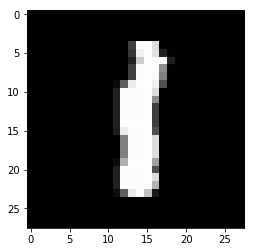

In [8]:
pylab.imshow(image)
pylab.show()

Stacking all the Input Images in a numpy array

In [9]:
%%time
all_images = []
for img_name in train_data_labels.filename:
    filepath = os.path.join(Images_dir, 'train', img_name)
    image = imageio.imread(filepath)
    image = image.astype('float32')
    all_images.append(image)

Wall time: 23.9 s


In [10]:
%%time
train_x = np.stack(all_images)

Wall time: 618 ms


Splitting the data into training and validation sets

In [11]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train_data_labels[:split_size], train_data_labels[split_size:]

Initializing Variables

In [12]:
#Number of Neurons in every layer
num_neurons_input = 28*28
num_neurons_output = 10
num_neurons_hidden = 500

In [13]:
#Placeholders
x = tf.placeholder(tf.float32, [None, num_neurons_input])
y = tf.placeholder(tf.float32, [None, num_neurons_output])

In [14]:
#Setting variables
epoch = 5
batch_size = 128
learning_rate = 0.01

In [15]:
weights = {
    'hidden': tf.Variable(tf.random_normal([num_neurons_input, num_neurons_hidden])),
    'output': tf.Variable(tf.random_normal([num_neurons_hidden, num_neurons_output]))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([num_neurons_hidden])),
    'output': tf.Variable(tf.random_normal([num_neurons_output]))
}

In [16]:
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

In [17]:
output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

In [18]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output_layer, labels=y))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, ).minimize(cost)

In [20]:
init = tf.global_variables_initializer()

In [21]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

In [22]:
def preproc(batch_normalize):
    batch_temp = batch_normalize/batch_normalize.max()
    return batch_temp

In [23]:
def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = np.random.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, num_neurons_input)
    batch_x = preproc(batch_x)
    
    batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
    batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y